# Sentiment and Thematic Analysis

Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import spacy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



/Users/elbethelzewdie/Documents/customer-satisfaction-week2/customer-satisfaction-week2/week2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/elbethelzewdie/Documents/customer-satisfaction-week2/customer-satisfaction-week2/notebooks/data/processed/reviews_processed.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  1555 non-null   object
 1   rating       1555 non-null   int64 
 2   review_date  1555 non-null   object
 3   bank_name    1555 non-null   object
 4   source       1555 non-null   object
dtypes: int64(1), object(4)
memory usage: 60.9+ KB


In [3]:
df.head()

,review_text,rating,review_date,bank_name,source
0,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia,Google Play
1,good jop,5,2025-11-27,Bank of Abyssinia,Google Play
2,Good application,4,2025-11-27,Commercial Bank of Ethiopia,Google Play
3,bad exprience...it is so crushed,1,2025-11-27,Bank of Abyssinia,Google Play
4,It is nice app,5,2025-11-26,Commercial Bank of Ethiopia,Google Play


## Text preprocessing

In [4]:
class TextCleaner:

    def __init__(self, df, text_column="review_text"):
        self.df = df
        self.text_column = text_column
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))

    # 1. Remove punctuation
    def remove_punctuation(self, text):
        return text.translate(str.maketrans("", "", string.punctuation))

    # 2. Convert to lowercase
    def to_lowercase(self, text):
        return text.lower()

    # 3. Remove stop words
    def remove_stopwords(self, text):
        words = text.split()
        filtered = [w for w in words if w not in self.stop_words]
        return " ".join(filtered)

    # 4️. Lemmatization
    def lemmatize_text(self, text):
        words = nltk.pos_tag(text.split())

        def get_wordnet_pos(tag):
            if tag.startswith('J'):
                return wordnet.ADJ
            elif tag.startswith('V'):
                return wordnet.VERB
            elif tag.startswith('N'):
                return wordnet.NOUN
            elif tag.startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN  # default POS

        lem_words = [
            self.lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            for word, pos in words
        ]

        return " ".join(lem_words)

    # 5. Apply the entire cleaning pipeline
    def clean_text(self):
        print("\n🔧 Cleaning text column...")

        self.df[self.text_column] = (
            self.df[self.text_column]
            .astype(str)
            .apply(self.remove_punctuation)
            .apply(self.to_lowercase)
            .apply(self.remove_stopwords)
            .apply(self.lemmatize_text)
        )

        print("✅ Text cleaning complete!")
        return self.df

In [5]:
cleaner = TextCleaner(df, text_column="review_text")
cleaned_df = cleaner.clean_text()

cleaned_df.to_csv("/Users/elbethelzewdie/Documents/customer-satisfaction-week2/customer-satisfaction-week2/notebooks/data/processed/cleaned_reviews.csv", index=False)

print("Saved cleaned_reviews.csv!")



🔧 Cleaning text column...
✅ Text cleaning complete!
Saved cleaned_reviews.csv!


Convert star rating to sentiment label

In [6]:
# Convert star rating to sentiment label
def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"
    
cleaned_df['sentiment_label'] = cleaned_df['rating'].apply(rating_to_label)

In [7]:
# Show output
cleaned_df.head()

,review_text,rating,review_date,bank_name,source,sentiment_label
0,advanced app stay safe,5,2025-11-27,Commercial Bank of Ethiopia,Google Play,positive
1,good jop,5,2025-11-27,Bank of Abyssinia,Google Play,positive
2,good application,4,2025-11-27,Commercial Bank of Ethiopia,Google Play,positive
3,bad exprienceit crush,1,2025-11-27,Bank of Abyssinia,Google Play,negative
4,nice app,5,2025-11-26,Commercial Bank of Ethiopia,Google Play,positive


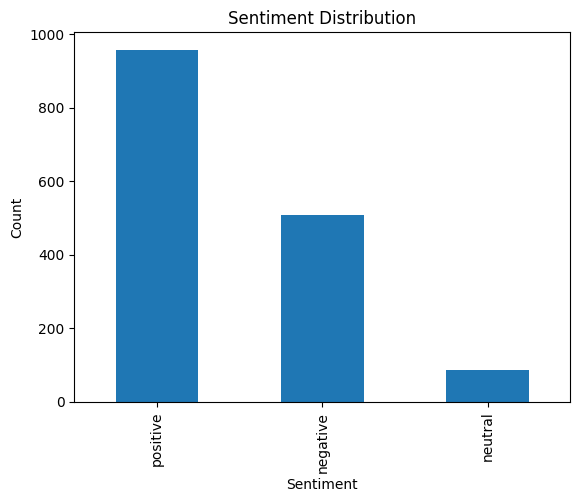

In [8]:
# Bar plot of sentiment labels
cleaned_df["sentiment_label"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


## Sentiment Analysis

### Lexicon-Based Sentiment (TextBlob & VADER)

### 1. TextBlob Lexicon

In [9]:
# Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
cleaned_df["tb_polarity"] = cleaned_df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
cleaned_df["tb_subjectivity"] = cleaned_df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

cleaned_df["tb_sentiment"] = cleaned_df["tb_polarity"].apply(polarity_to_label)

# Show output
cleaned_df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]

,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,advanced app stay safe,5,0.450000,0.550000,positive
1,good jop,5,0.700000,0.600000,positive
2,good application,4,0.700000,0.600000,positive
3,bad exprienceit crush,1,-0.700000,0.666667,negative
4,nice app,5,0.600000,1.000000,positive
...,...,...,...,...,...
1550,play,5,0.000000,0.000000,neutral
1551,ayseram mnm,1,0.000000,0.000000,neutral
1552,ethiopian internet banking abbisiniya internet...,1,-0.650000,0.700000,negative
1553,work good last update update asks disable deve...,2,0.129167,0.451389,positive


### 2. VADER Lexicon

In [10]:
# Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts
sia = SentimentIntensityAnalyzer()

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
cleaned_df["vader_compound"] = cleaned_df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

cleaned_df["vader_sentiment"] = cleaned_df["vader_compound"].apply(vader_label)

# Show output
cleaned_df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]

,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,advanced app stay safe,5,0.450000,0.5994,positive
1,good jop,5,0.700000,0.4404,positive
2,good application,4,0.700000,0.4404,positive
3,bad exprienceit crush,1,-0.700000,-0.6249,negative
4,nice app,5,0.600000,0.4215,positive
...,...,...,...,...,...
1550,play,5,0.000000,0.3400,positive
1551,ayseram mnm,1,0.000000,0.0000,neutral
1552,ethiopian internet banking abbisiniya internet...,1,-0.650000,-0.5859,negative
1553,work good last update update asks disable deve...,2,0.129167,0.5178,positive


#### Visualization of lexicon scores vs rating

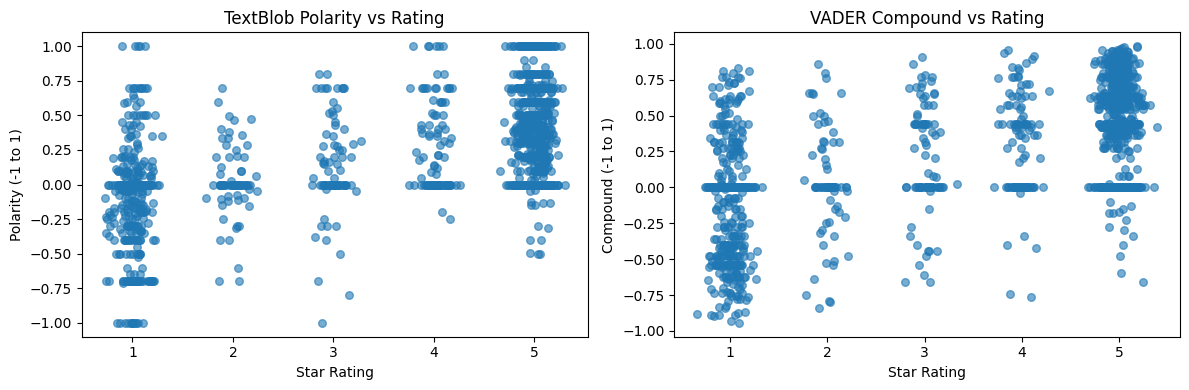

In [11]:
# See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def add_jitter(arr, scale=0.1):
    return arr + np.random.normal(0, scale, len(arr))

axes[0].scatter(add_jitter(cleaned_df["rating"]), cleaned_df["tb_polarity"], 
               alpha=0.6, s=30)
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")
axes[0].set_xticks([1, 2, 3, 4, 5])

axes[1].scatter(add_jitter(cleaned_df["rating"]), cleaned_df["vader_compound"], 
               alpha=0.6, s=30)
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")
axes[1].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()


### Sentiment Analysis Using DistilBERT

In [12]:
# Use the same model for sentiment analysis
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    return_all_scores=True  # This allows detecting NEUTRAL as well
)

Device set to use mps:0
/Users/elbethelzewdie/Documents/customer-satisfaction-week2/customer-satisfaction-week2/week2/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [13]:
def text_to_sentiment(text, threshold=0.6):
    results = sentiment_analyzer(text)[0]
    pos_score = next(item["score"] for item in results if item["label"] == "POSITIVE")
    neg_score = next(item["score"] for item in results if item["label"] == "NEGATIVE")
    
    # Heuristic for NEUTRAL if model is unsure
    if max(pos_score, neg_score) < threshold:
        return "NEUTRAL", max(pos_score, neg_score)
    
    label = "POSITIVE" if pos_score > neg_score else "NEGATIVE"
    score = max(pos_score, neg_score)
    return label, score


In [14]:
# Add new columns for model-predicted sentiment
cleaned_df["model_sentiment_label"], cleaned_df["model_sentiment_score"] = zip(*cleaned_df["review_text"].apply(text_to_sentiment))


In [15]:
# Normalize both columns
cleaned_df["sentiment_label"] = cleaned_df["sentiment_label"].str.upper()
cleaned_df["model_sentiment_label"] = cleaned_df["model_sentiment_label"].str.upper()
cleaned_df["tb_sentiment"] = cleaned_df["tb_sentiment"].str.upper()
cleaned_df["vader_sentiment"] = cleaned_df["vader_sentiment"].str.upper()

In [16]:
cleaned_df["sentiment_match_distilbert"] = (
    cleaned_df["sentiment_label"] == cleaned_df["model_sentiment_label"]
)

cleaned_df["sentiment_match_textblob"] = (
    cleaned_df["sentiment_label"] == cleaned_df["tb_sentiment"]
)

cleaned_df["sentiment_match_vader"] = (
    cleaned_df["sentiment_label"] == cleaned_df["vader_sentiment"]
)

In [17]:
print(cleaned_df[[
    "review_text",
    "sentiment_label",
    "model_sentiment_label",
    "sentiment_match_distilbert",
    "tb_sentiment",
    "sentiment_match_textblob",
    "vader_sentiment",
    "sentiment_match_vader"
]].head())

              review_text sentiment_label model_sentiment_label  \
0  advanced app stay safe        POSITIVE              POSITIVE   
1                good jop        POSITIVE              POSITIVE   
2        good application        POSITIVE              POSITIVE   
3   bad exprienceit crush        NEGATIVE              NEGATIVE   
4                nice app        POSITIVE              POSITIVE   

   sentiment_match_distilbert tb_sentiment  sentiment_match_textblob  \
0                        True     POSITIVE                      True   
1                        True     POSITIVE                      True   
2                        True     POSITIVE                      True   
3                        True     NEGATIVE                      True   
4                        True     POSITIVE                      True   

  vader_sentiment  sentiment_match_vader  
0        POSITIVE                   True  
1        POSITIVE                   True  
2        POSITIVE                  

In [18]:
print("DistilBERT match rate:", cleaned_df["sentiment_match_distilbert"].mean())
print("TextBlob match rate:", cleaned_df["sentiment_match_textblob"].mean())
print("VADER match rate:", cleaned_df["sentiment_match_vader"].mean())

DistilBERT match rate: 0.7440514469453376
TextBlob match rate: 0.512540192926045
VADER match rate: 0.5890675241157556


In [19]:
cleaned_df[[
    "sentiment_match_distilbert",
    "sentiment_match_textblob",
    "sentiment_match_vader"
]].sum()

sentiment_match_distilbert    1157
sentiment_match_textblob       797
sentiment_match_vader          916
dtype: int64

In [ ]:
# Map sentiment labels to numeric values
sentiment_map = {"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1}

cleaned_df["sentiment_numeric"] = cleaned_df["sentiment_label"].map(sentiment_map)


In [ ]:
# Aggregate by bank and rating
agg_df = (
    cleaned_df
    .groupby(["bank_name", "rating"])
    .agg(
        mean_sentiment=("sentiment_numeric", "mean"),
        review_count=("sentiment_numeric", "count")
    )
    .reset_index()
)

print(agg_df)


                      bank_name  rating  mean_sentiment  review_count
0             Bank of Abyssinia       1            -1.0           269
1             Bank of Abyssinia       2            -1.0            28
2             Bank of Abyssinia       3             0.0            37
3             Bank of Abyssinia       4             1.0            25
4             Bank of Abyssinia       5             1.0           187
5   Commercial Bank of Ethiopia       1            -1.0            88
6   Commercial Bank of Ethiopia       2            -1.0            22
7   Commercial Bank of Ethiopia       3             0.0            30
8   Commercial Bank of Ethiopia       4             1.0            57
9   Commercial Bank of Ethiopia       5             1.0           323
10                  Dashen Bank       1            -1.0            78
11                  Dashen Bank       2            -1.0            24
12                  Dashen Bank       3             0.0            21
13                  

## Thematic Analysis


### Frequency-Based vs TF-IDF

1. Frequency-based representation (Bag of Words)

In [22]:
# Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(cleaned_df["review_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
160,app,722
236,bank,222
827,good,174
1897,use,169
1993,work,167
271,best,124
241,banking,121
486,dashen,89
1304,one,88
1197,mobile,88


Visualize top frequent words

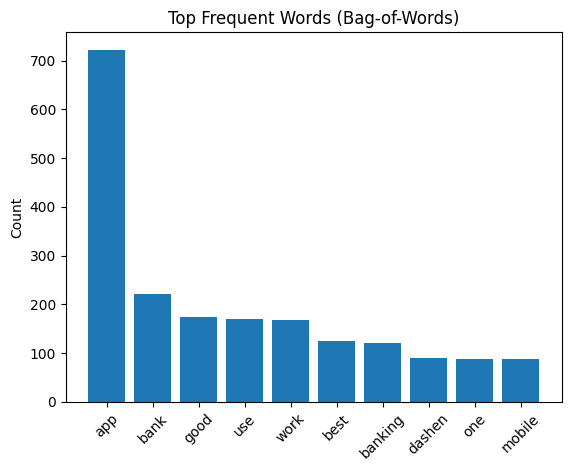

In [23]:
# Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


2. TF-IDF representation

TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

In [24]:
# TF-IDF representation

tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(cleaned_df["review_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
160,app,0.079075
827,good,0.050415
271,best,0.039097
1993,work,0.029706
236,bank,0.028826
1897,use,0.026325
1257,nice,0.021967
241,banking,0.019774
231,bad,0.019667
714,fast,0.019036


Compare raw frequency Vs TF-IDF

In [25]:
# Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))

Top 10 by raw frequency:


,word,count
160,app,722
236,bank,222
827,good,174
1897,use,169
1993,work,167
271,best,124
241,banking,121
486,dashen,89
1304,one,88
1197,mobile,88



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
160,app,0.079075
827,good,0.050415
271,best,0.039097
1993,work,0.029706
236,bank,0.028826
1897,use,0.026325
1257,nice,0.021967
241,banking,0.019774
231,bad,0.019667
714,fast,0.019036


### N-Gram Keyword Extraction

In [ ]:
# N-Gram Keyword Extraction (Bigrams)
vectorizer = CountVectorizer(
    ngram_range=(2, 2),   
)

# 2. Fit and transform the review_text column
X = vectorizer.fit_transform(df['review_text'])

# 3. Sum occurrences of each bigram across all reviews
bigram_counts = X.sum(axis=0)

# 4. Map counts to bigram phrases
bigram_freq = [(bigram, bigram_counts[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]

# 5. Sort by frequency descending
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# 6. Show top 10 bigrams
top_10_bigrams = bigram_freq[:10]
print("Top 10 bigram phrases:")
for bigram, count in top_10_bigrams:
    print(f"{bigram}: {count}")

Top 10 bigram phrases:
mobile banking: 58
dashen bank: 50
banking app: 48
app ever: 45
super app: 39
best app: 37
easy use: 35
good app: 31
bad app: 31
doesnt work: 30


### Topic Modeling (LDA)

In [26]:
# Tokenize text (very simple split for demo)
cleaned_df["tokens"] = cleaned_df["review_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(cleaned_df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in cleaned_df["tokens"]]

In [28]:
cleaned_df[["review_text", "tokens"]].head()

,review_text,tokens
0,advanced app stay safe,"[advanced, app, stay, safe]"
1,good jop,"[good, jop]"
2,good application,"[good, application]"
3,bad exprienceit crush,"[bad, exprienceit, crush]"
4,nice app,"[nice, app]"


In [ ]:

# Create 
dictionary = Dictionary(cleaned_df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in cleaned_df["tokens"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [30]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")


--- Topic 1 ---
app              weight=0.0518
good             weight=0.0268
best             weight=0.0182
use              weight=0.0182
bank             weight=0.0159
banking          weight=0.0136
one              weight=0.0119
mobile           weight=0.0112
make             weight=0.0100
application      weight=0.0097

--- Topic 2 ---
app              weight=0.0665
work             weight=0.0211
bank             weight=0.0206
bad              weight=0.0118
update           weight=0.0112
like             weight=0.0106
ever             weight=0.0096
use              weight=0.0096
nice             weight=0.0091
time             weight=0.0089


Part-of-Speech Tagging (Noun Extraction)

In [ ]:
# extract nouns 
nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

cleaned_df["nouns"] = cleaned_df["review_text"].apply(extract_nouns)
cleaned_df[["review_text", "nouns"]]

,review_text,nouns
0,advanced app stay safe,[app]
1,good jop,[jop]
2,good application,[application]
3,bad exprienceit crush,"[exprienceit, crush]"
4,nice app,[app]
...,...,...
1550,play,[]
1551,ayseram mnm,[]
1552,ethiopian internet banking abbisiniya internet...,"[internet, banking, abbisiniya, internet, bank..."
1553,work good last update update asks disable deve...,"[update, update, developer, option, developer,..."


### Define Themes and Keyword Mapping

In [40]:
# Predefined themes and associated keywords/bigrams
THEME_KEYWORDS = {
    "Account Access Issues": ["login issue", "password reset", "account blocked", "cannot login", "authentication failure"],
    "Transaction Performance": ["transfer failed", "payment error", "slow transfer", "pending transaction", "transaction delay"],
    "User Interface & Experience": ["user interface", "app crash", "navigation problem", "UI design", "app freeze"],
    "Customer Support": ["customer support", "call center", "support response", "help desk", "agent response"],
    "Feature Requests": ["feature request", "add feature", "new feature", "support for", "would like"]
}


In [ ]:
# Define a function to assign themes
def assign_themes_to_bigrams(bigram_list):
    """
    Map a list of bigrams to their corresponding themes. Returns a list of themes.
    """
    matched_themes = set()
    for bigram in bigram_list:
        for theme, keywords in THEME_KEYWORDS.items():
            if bigram.lower() in keywords:
                matched_themes.add(theme)
    # If no match found, assign "Other"
    return list(matched_themes) if matched_themes else ["Other"]


In [42]:
cleaned_df["themes"] = cleaned_df["keywords"].apply(assign_themes_to_bigrams)

# Optional: Inspect first rows
cleaned_df[["bank_name", "keywords", "themes"]].head(10)

,bank_name,keywords,themes
0,Commercial Bank of Ethiopia,"[error, essay, app, safe, advanced]",[Other]
1,Bank of Abyssinia,"[ethiopian bank, even, enjoy, yet, good]",[Other]
2,Commercial Bank of Ethiopia,"[even, enough, good, application, good applica...",[Other]
3,Bank of Abyssinia,"[even open, even work, ensure, bad, crush]",[Other]
4,Commercial Bank of Ethiopia,"[error, essay, app, nice, nice app]",[Other]
5,Dashen Bank,"[fast easy, app available, thank dashen, area,...",[Other]
6,Commercial Bank of Ethiopia,"[ensure, yet, app, good, good app]",[Other]
7,Bank of Abyssinia,"[work, time, properly, work properly, time work]",[Other]
8,Commercial Bank of Ethiopia,"[even, even open, ensure, yet, best]",[Other]
9,Commercial Bank of Ethiopia,"[error, essay, app, nice, nice app]",[Other]


In [43]:
theme_summary = (
    cleaned_df.explode("themes")  # explode list of themes into rows
      .groupby(["bank_name", "themes"])
      .size()
      .reset_index(name="count")
      .sort_values(["bank_name", "count"], ascending=[True, False])
)

print(theme_summary)


                     bank_name                       themes  count
1            Bank of Abyssinia                        Other    542
2            Bank of Abyssinia  User Interface & Experience      3
0            Bank of Abyssinia             Feature Requests      1
4  Commercial Bank of Ethiopia                        Other    516
3  Commercial Bank of Ethiopia             Feature Requests      3
5  Commercial Bank of Ethiopia  User Interface & Experience      1
6                  Dashen Bank                        Other    485
7                  Dashen Bank  User Interface & Experience      4
